# Generative Adversarial Networks
In this assignment, you’ll get hands-on experience coding and training GANs. This assignment is divided into two parts: in the first part, we will implement a specific type of GAN designed to process images, called a Conditional GAN (CGAN). We’ll train the CGAN to generate images from samples of random noise. In the second part, we will interpolate some images for that you will be given a model.

**Note:** Please attempt this assignment on Google Colab, since that will speed up the training process. 

In [5]:
import os
import cv2
import keras
import random
import numpy as np
from glob import glob
import tensorflow as tf
import keras.backend as K
from keras.layers import *
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow_datasets as tfds
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.initializers import RandomNormal
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.utils.generic_utils import Progbar
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, LeakyReLU, Flatten, Dropout, Concatenate, Embedding



**NOTE** 
1. You need to change your notebook name to CS437_DL_HW5_[YOUR ID] 
2. Just upload the Notebook, you don't need to zip it 

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
# Use these variables
ROLLNUMBER = 22100215
BATCH_SIZE = 64
IMAGE_SHAPE = (96,96,3)
CHANNELS = 3
NOISE_DIM = 100
EPOCHS = 150
HEIGHT, WIDTH, DEPTH = 96,96,96
N_CLASSES = 10
SIZE = HEIGHT * WIDTH * DEPTH    

In [9]:
## Helper Functions
def sample_noise():
    return np.reshape(np.random.randn(NOISE_DIM * BATCH_SIZE),(BATCH_SIZE,NOISE_DIM))

def load_data():
    dataloader = tfds.load("Stl10", as_supervised=True)
    train, test = dataloader["train"], dataloader["test"]
    return (train, test)

def create_image_grid(array, ncols=None):
    num_images, cell_h, cell_w, channels = array.shape
    if not ncols:
        ncols = int(np.sqrt(num_images))
    nrows = int(np.math.floor(num_images / float(ncols)))
    result = np.zeros((cell_h*nrows, cell_w*ncols, channels), dtype=array.dtype)
    for i in range(0, nrows):
        for j in range(0, ncols):
            result[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w, :] = array[i*ncols+j]

    if channels == 1:
        result = result.squeeze()
    return result

def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        im = im/np.amax(im)
        im = np.clip(im, 0, 1)
        ax.imshow(im)
        ax.axis("off")
    
    plt.suptitle(title_text, fontsize=20)
    plt.show()

### Step 1 | Load the dataset




In [6]:

TRAIN_DATA_PATH ='/content/drive/MyDrive/stl10_binary/train_X.bin'
TEST_DATA_PATH ='/content/drive/MyDrive/stl10_binary/test_X.bin'
TRAIN_LABELS_PATH ='/content/drive/MyDrive/stl10_binary/train_y.bin'
TEST_LABELS_PATH ='/content/drive/MyDrive/stl10_binary/test_y.bin'
CLASS_NAMES_PATH ='/content/drive/MyDrive/stl10_binary/class_names.txt'

**Note**| Dataset is in PrefetchDataset shape, you need to extract the images and labels out of it. After that you may want to apply preprocessing i.e., changing the d-type and labels to one-hot labels

https://www.tensorflow.org/datasets/performances

In [7]:
def read_labels(path_to_labels):
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels
        
def read_all_images(path_to_data):
    with open(path_to_data, 'rb') as f:
        everything = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(everything, (-1, DEPTH, WIDTH, HEIGHT))
        images = np.transpose(images, (0, 3, 2, 1))
        return images

def load_dataset():
    x_train = read_all_images(TRAIN_DATA_PATH)
    y_train = read_labels(TRAIN_LABELS_PATH)
    x_test = read_all_images(TEST_DATA_PATH)
    y_test = read_labels(TEST_LABELS_PATH)
    x_train = x_train.astype('float32')
    x_train = (x_train - 127.5)/127.5
    x_test = x_test.astype('float32')
    x_test = (x_test - 127.5)/127.5
    y_train -= 1
    y_test -= 1
    return (x_train, y_train), (x_test, y_test)

In [8]:
(x_train, y_train), (x_test, y_test) = load_dataset()

(5000, 96, 96, 3) (5000,) (8000, 96, 96, 3) (8000,)


#### Combine the X_train and X_test and their labels as you are not required the test set to evaluate Gan.

In [9]:
X_train = np.concatenate((x_train,x_test))
Y_train = np.concatenate((y_train,y_test))

After that your X_train.shape yeilds (13000, 96, 96, 3)

In [66]:
print(X_train.shape)


(13000, 96, 96, 3)


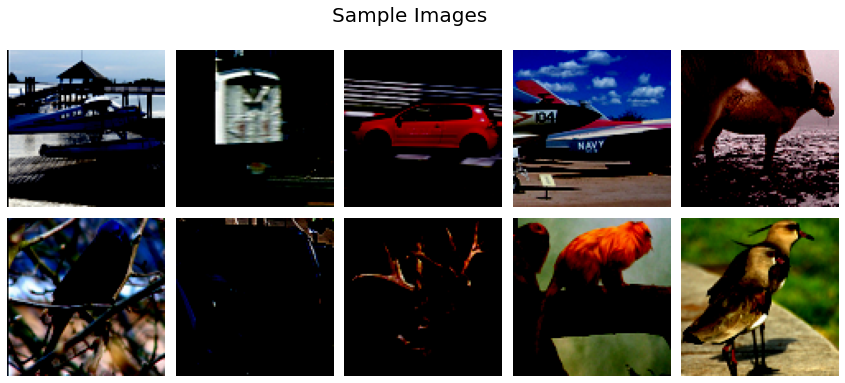

In [67]:
# X_train = np.array(images_)
sample_images = X_train[330:340]
display_image_grid(sample_images, 2, 5, "Sample Images")

### Step 2 | Implementing the Discriminator Network
The discriminator network distinguishes between real and fake samples using conditional probability.

**Some Important points**:
- Pass in the following arguments in your Convolutional Layers: padding='same',use_bias=False
- Concatenate the input image and label (see the comparison of Gan vs CGAN)
- After the last convolutional layer, Flatten the output and then add the final dense layer for prediction
- Use LeakyRelu and BatchNormalization after each convolution if required
- It's the 2 input and single output model

Implement the discriminator in the cell below:

In [23]:
def define_discriminator(input_shape = (96,96,3),num_classes = 10):
  in_label = Input(shape=(1,))
  label = Embedding(num_classes, 50)(in_label)
  n_nodes = input_shape[0] * input_shape[1]
  label = Dense(n_nodes)(in_label)
  label = Reshape((input_shape[0], input_shape[1], 1))(label)
  image = Input(shape=input_shape)
  merge = Concatenate()([image, label])
  out = Conv2D(128, (3,3), strides=(2,2), padding='same',use_bias = False)(merge)
  out = LeakyReLU(alpha=0.2)(out)
  out = Conv2D(128, (3,3), strides=(2,2), padding='same',use_bias = False)(out)
  out = LeakyReLU(alpha=0.2)(out)
  out = Conv2D(128, (3,3), strides=(2,2), padding='same',use_bias = False)(out)
  out = LeakyReLU(alpha=0.2)(out)
  out = Flatten()(out)
  out = Dropout(0.4)(out)
  out_layer = Dense(1, activation='sigmoid')(out)
  model = Model([image, in_label], out_layer)
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.5))
  return model

In [24]:
discriminator = define_discriminator()

### Step 3 | Implementing the Generator Network
Now, we will implement the generator of the CGAN.

**Some important points:**
- All intermediate Convolutional/ Conv2DTranspose layers will have relu/ leakyrelu activation except the last one, which will have tanh.
- To improve the performance you can use kernel_initializer, Batchnormalization layer which suits you the best

Implement the generator in the cell below

In [25]:
def define_generator(latent_dim, n_classes=10):
  input_label = Input(shape=(1,))
  label = Embedding(n_classes, 50)(input_label)
  n_nodes = 12 * 12
  label = Dense(n_nodes)(label)
  label = Reshape((12, 12, 1))(label)
  in_lat = Input(shape=(latent_dim,))
  n_nodes = 128 * 12 * 12
  out = Dense(n_nodes)(in_lat)
  out = LeakyReLU(alpha=0.2)(out)
  out = Reshape((12, 12, 128))(out)
  out = Concatenate()([out, label])
  out = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(out)
  out = LeakyReLU(alpha=0.2)(out)
  out = BatchNormalization()(out)
  out = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(out)
  out = LeakyReLU(alpha=0.2)(out)
  out = BatchNormalization()(out)
  out = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(out)
  out = LeakyReLU(alpha=0.2)(out)
  out = BatchNormalization()(out)
  out_layer = Conv2D(3, (7,7), activation='tanh', padding='same')(out)
  model = Model([in_lat, input_label], out_layer)

  return model

In [26]:
generator = define_generator(latent_dim = 100)

### Step 4 | CGAN Training
Next, you will implement the training loop for the CGAN. The pseudo-code is given below.

**Algorithm:**    
1. Draw m training examples {x<sup>(1)</sup>,...,x<sup>(m)</sup>} from the data distribution p<sub>data</sub>.
2. Draw m noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
3. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
4. Train discriminator (D) on real/fake data conditioned on their respective one-hot labels and then update the parameters.
5. Draw m new noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
6. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
7. Freeze the discriminator.
8. Compute generator's loss then update the parameters.
9. Unfreeze the discriminator.

Before we move to writing the training loop, we will need to create a "combined" model that will attach the discriminator over the generator. This model will be used to train the generator as the discriminator will act as an adversary for the generator and force it to generate realistic images.

In this function below you need to create a model that:
- Takes noise z as input
- Gets a fake image generated from the generator using this noise z
- "Freezes" the discriminator (Setting all layers of the discriminator as untrainable)
- Outputs the output of the discriminator based on the input z.
Remember to compile the model before returning it.

In [27]:
def define_gan(g_model, d_model):
	d_model.trainable = False
	gen_noise, gen_label = g_model.input
	gen_output = g_model.output
	gan_output = d_model([gen_output, gen_label])
	model = Model([gen_noise, gen_label], gan_output)
	opt = Adam(lr=0.0001, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [28]:
gan = define_gan(generator,discriminator)
gan.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 18432)        1861632     input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
____________________________________________________________________________________________

#### Scale Images to the Range [-1,1]
We already know that normalizing images improves training for any model. We will scale our images in the range [-1,1] since we are using a tanh activation in our generator. This will make the fake generated images and real images in the same range and will enable our discriminator to learn better.    
Implement the following function to normalize a numpy array containing images. 

**Note:** Fill it, If you haven't done that already. See if it helps in the training or not and add your comment below.

In [18]:
'''Add your Comment'''

'Add your Comment'

#### Use Label Smoothing
Normally, we use hard labels 1s and 0s to train our GANs. Researchers have suggested to smooth labels and use "soft" labels . This is said to have a "regularizing" effect on the training.

#### Real Label Smoothing
For Real labels, i.e. 1s, we will smooth the labels uniformly between [0.7,1.2]. Use np.random.random for this.

In [21]:
def smooth_real_labels(y):
  shape = y.shape
  return y - 0.3 + (np.random.random(y.shape) * 0.5)

#### Fake Label Smoothing

In [22]:
def smooth_fake_labels(y):
    return y + np.random.random(y.shape) * 0.3

Write your training loop in the cell bellow. Some important points to keep in mind:
- You need to compile the discriminator after creating an instance using build_discriminator()
- To train your models, we won't make use of <code>fit</code> instead we will use <code>train_on_batch</code> to train our model over batches. This method will return your model's loss over a particular batch, which you will use to output and store your history of losses.
- Additionally, we will be generating samples after some epochs and storing the result on disk. You can modify according to your need.

#### Training the GAN


In [24]:
# Setup Models here

In [25]:
DATASET = [X_train,Y_train]

In [15]:
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = np.random.randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = np.ones((n_samples, 1))
	return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  # generate points in the latent space
  x_input = np.random.randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = np.random.randint(0, n_classes, n_samples)
  return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

In [27]:
BASE_DIR = '/content/drive/MyDrive/HW5DL'

In [53]:
def training_loop(intervals=10):
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(EPOCHS):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        for i,index in enumerate(indices):
            X_real = DATASET[0][index:index+32]
            labels_real = DATASET[1][index:index+32]
            labels_real = smooth_real_labels(labels_real)
            y_real = np.ones((32, 1))
            d_loss1 = discriminator.train_on_batch([X_real, labels_real], y_real)

            [X_fake, labels_fake], y_fake = generate_fake_samples(generator, 100, 32)
            d_loss2 = discriminator.train_on_batch([X_fake, labels_fake], y_fake)
            labels_fake = smooth_fake_labels(labels_fake)
            
            disc_loss = (d_loss1 + d_loss2) * 0.5
            epoch_disc_loss.append(disc_loss)
            [z_input, labels_input] = generate_latent_points(100, 32)
            y_gan = np.ones((32, 1))
            g_loss = gan.train_on_batch([z_input, labels_input], y_gan)

            gen_loss = g_loss
            epoch_gen_loss.append(gen_loss)

            progress_bar.update(i+1)
        if not (e%intervals):
            discriminator.save_weights(os.path.join(BASE_DIR,'discriminator.h5'),True)
            generator.save_weights(os.path.join(BASE_DIR,'generator.h5'),True)
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)

        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

In [54]:
all_disc_loss_mod,all_gen_loss_mod = training_loop()

203/203 [==============================] - 85s 419ms/step
Epoch: 1 | Discriminator Loss: 0.213342 | Generator Loss: 7.109203
203/203 [==============================] - 86s 421ms/step
Epoch: 2 | Discriminator Loss: 0.178397 | Generator Loss: 3.768602
203/203 [==============================] - 85s 420ms/step
Epoch: 3 | Discriminator Loss: 0.147019 | Generator Loss: 2.537479
203/203 [==============================] - 85s 421ms/step
Epoch: 4 | Discriminator Loss: 0.209553 | Generator Loss: 3.425415
203/203 [==============================] - 85s 421ms/step
Epoch: 5 | Discriminator Loss: 0.168658 | Generator Loss: 3.637400
203/203 [==============================] - 85s 420ms/step
Epoch: 6 | Discriminator Loss: 0.201715 | Generator Loss: 2.810963
203/203 [==============================] - 85s 419ms/step
Epoch: 7 | Discriminator Loss: 0.233822 | Generator Loss: 3.506004
203/203 [==============================] - 85s 420ms/step
Epoch: 8 | Discriminator Loss: 0.239560 | Generator Loss: 2.781771


#### Step 5 | Generating Samples and Analysis

- Generate random noise samples and their corresponding fake images. For you convience, you can find some samples here [Real Samples](https://drive.google.com/file/d/1bNiPFu4StxBvdhqslM5d7ad3-mycwrMu/view?usp=sharing)
[Fake Samples](https://drive.google.com/file/d/12fIGZ_6NAC58KEgQuQfeOYVOFw45AjdD/view?usp=sharing)
These are just fake samples, you can generate better images. 

In [30]:
generator.load_weights("/drive/MyDrive/DL_PA_5/generator.h5")

In [79]:
def plot_loss(gen_loss,disc_loss):
    plt.plot(gen_loss)
    plt.plot(disc_loss)
    plt.title('GAN Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

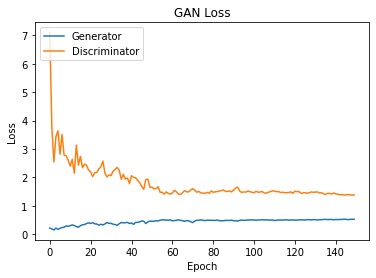

In [80]:
plot_loss(all_disc_loss_mod,all_gen_loss_mod)

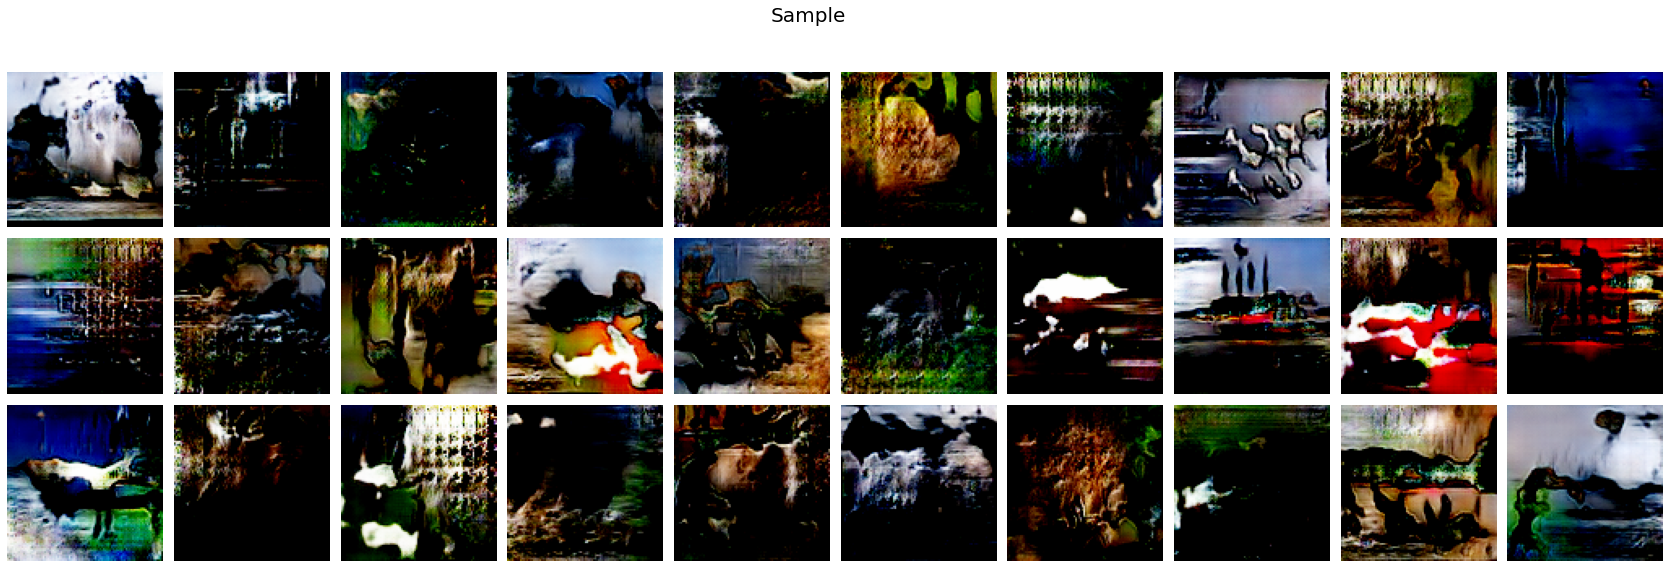

In [33]:
[Inputx, labelsx]= generate_latent_points(100, 30)
gen_image = generator.predict([Inputx, labelsx])
display_image_grid(gen_image,3,10,"Sample")


## Task 1| Part (b) - [Grads Only/ 10% Bonus marks for Undergradudates ]

Use Mean squared Error Loss function for CGANs and differentiate between generated images.
Add your answer which Loss function (MSE, BCE) is better for stl10 classification and why.





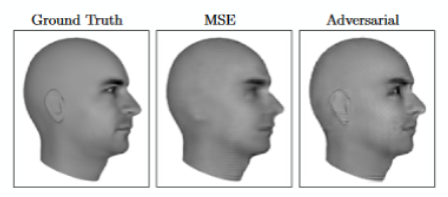

In [ ]:
# WRITE YOUR CODE HERE
'''
Modify you networks
'''

## Task 2 | Interpolation

We'll use the same dataset as used for assignment 4. Model Weight is provided

In [1]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [3]:
# replace this your google drive path of the zip file of dataset provided with this homework
!unzip -o -q "/drive/MyDrive/Dataset_assignment4/ffhq-dataset.zip" -d "/content/data2/"

In [6]:
# data folder path in colab runtime enviroment
DATA_FOLDER = '/content/data2'

# fetching all the filenmaes to read them later in generator
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.png')))

# total images in directory
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 70000


In [7]:
INPUT_DIM = (128,128,3) 
BATCH_SIZE = 512        
Z_DIM = 00             

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, target_size = INPUT_DIM[:2], 
                                                                   batch_size = BATCH_SIZE, shuffle = True, 
                                                                   class_mode = 'input', subset = 'training')

Found 70000 images belonging to 1 classes.


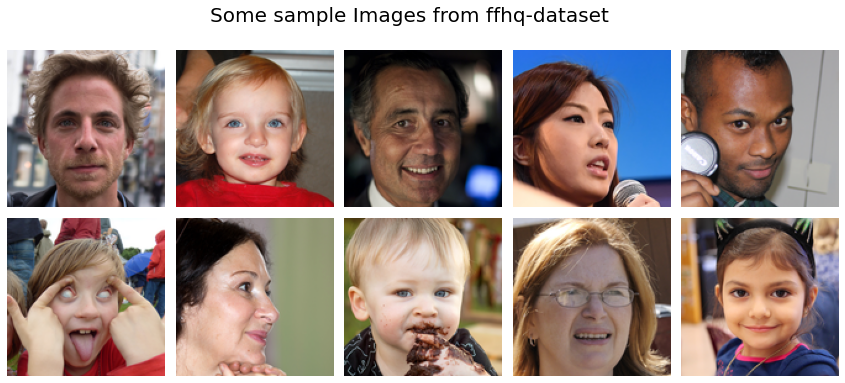

In [10]:
# a batch of 512 images returned by data generator
sample_images = next(data_flow)[0] 

# only taking 10 of those to display
sample_images = sample_images[:10]

# displaying the images
display_image_grid(sample_images, 2, 5, "Some sample Images from ffhq-dataset")

*  Model weights are provided to you, use that model and interpolate 5 images.
*  If you want to train the model from scratch it's up to you.



In [11]:
def define_generator():
	model = Sequential()
	n_nodes = 128 * 4 * 4
	model.add(Dense(n_nodes, input_dim=100))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 128)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 
	model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
	return model

In [17]:
# Some Fake Samples
generator = define_generator()
generator.load_weights('/drive/MyDrive/generator.h5')
[Inputx, labelsx]= generate_latent_points(100, 10)
X = generator.predict(Inputx)


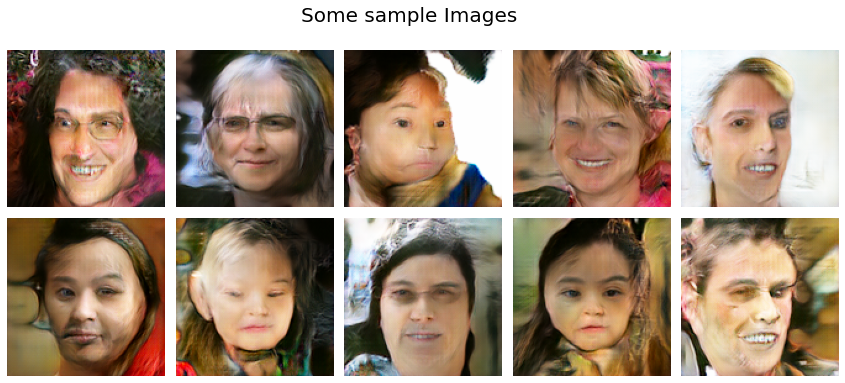

In [18]:
display_image_grid(X, 2, 5, "Some sample Images")

You can play around with the images for example:
	
1.  *Glasses on Woman - Neutral Woman + Neutral Man = Glasses on Man*
2.  *Smile on Woman - Neutral Woman + Neutral Man = smile on Man*

Create 10 different scenarios and display

In [19]:
def interpolate_points(p1, p2, n_steps=10):
	ratios = np.linspace(0, 1, num=n_steps)
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)

In [20]:
# WRITE YOUR CODE HERE
def interpolation():
  images = []
  for i in range(10):
    pts,_ = generate_latent_points(100, 2)
    interpolated = interpolate_points(pts[0], pts[1])
    X = generator.predict(interpolated)
    display_image_grid(X, 1, 10, "Transition from one image to another")

#### Display Results

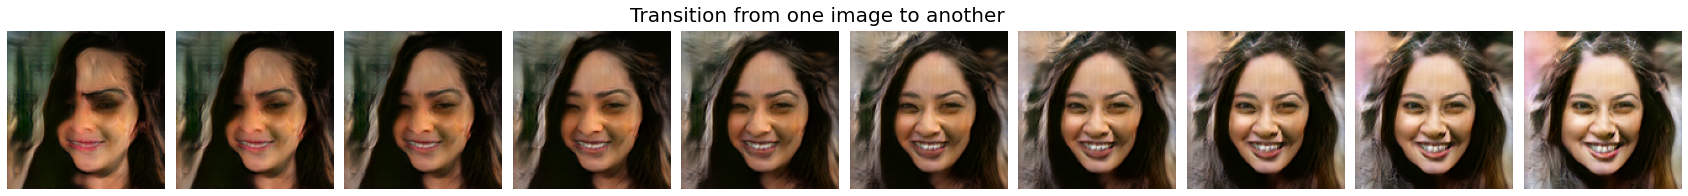

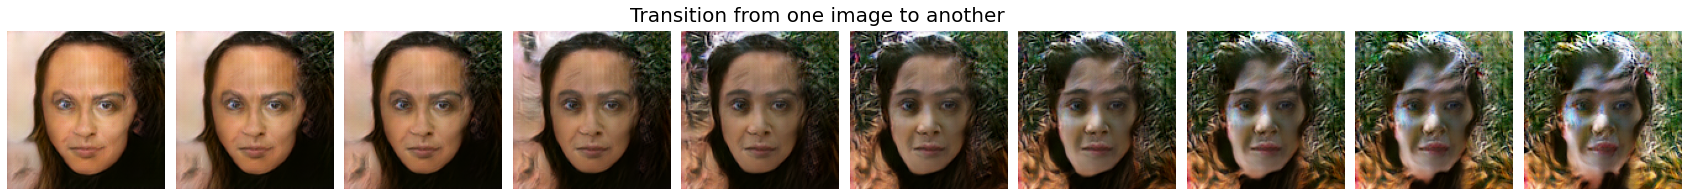

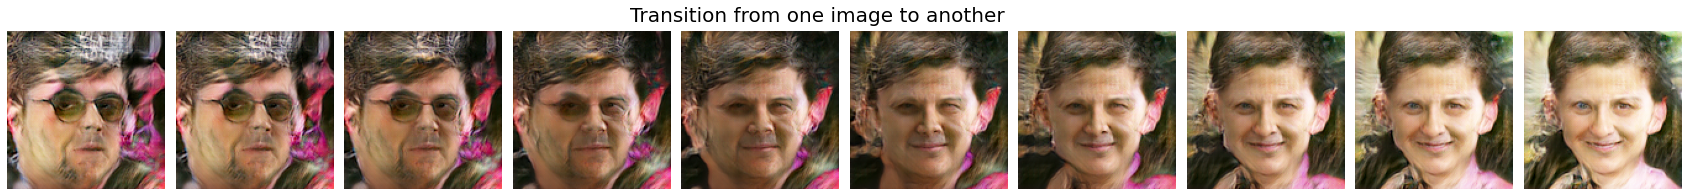

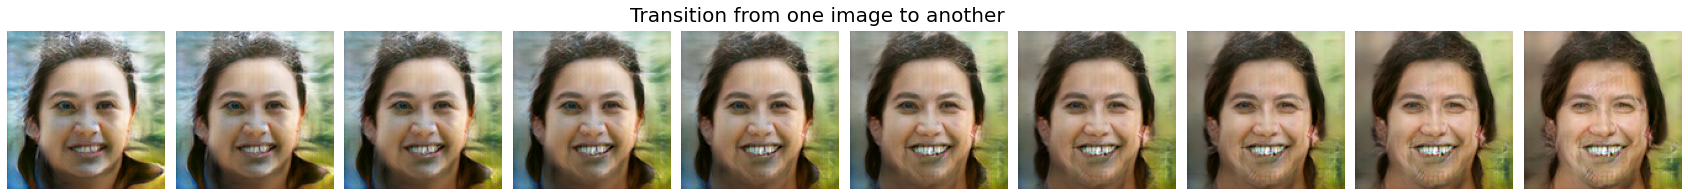

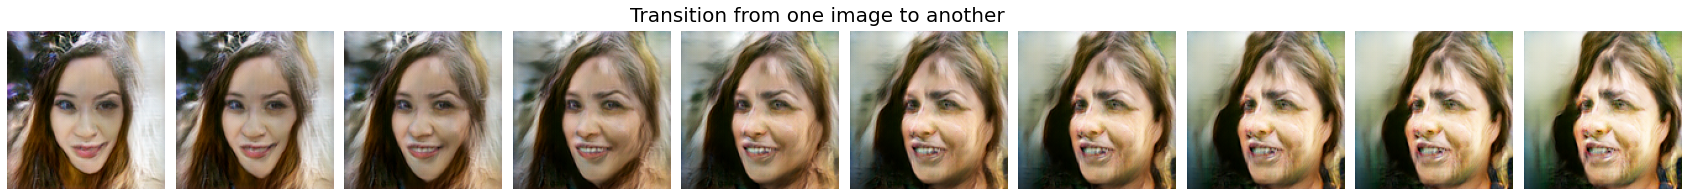

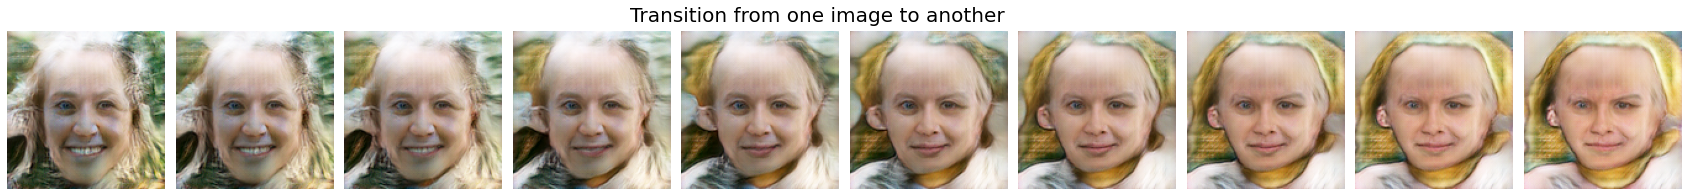

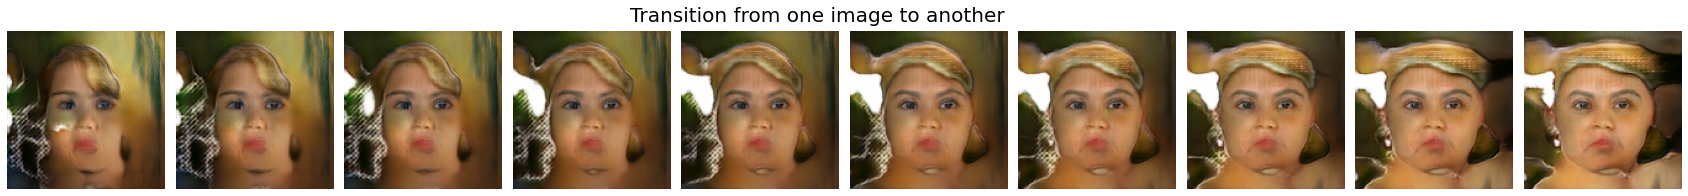

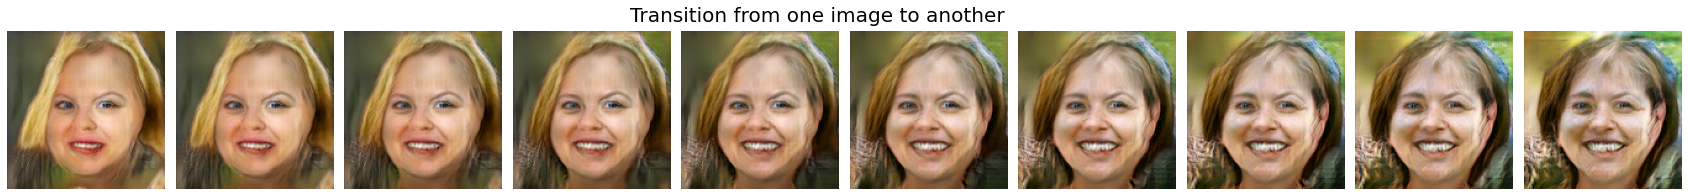

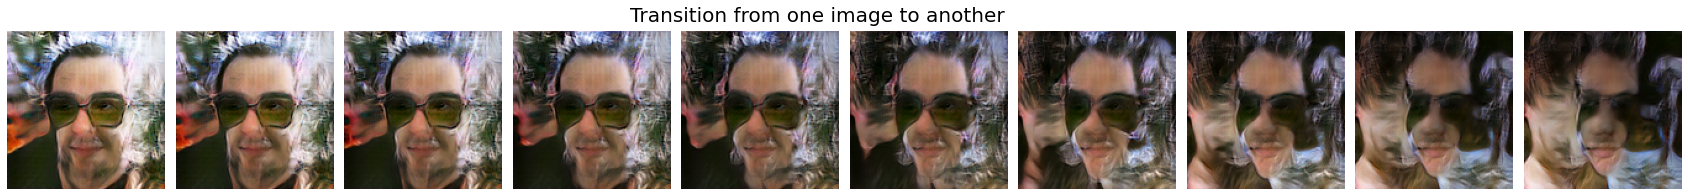

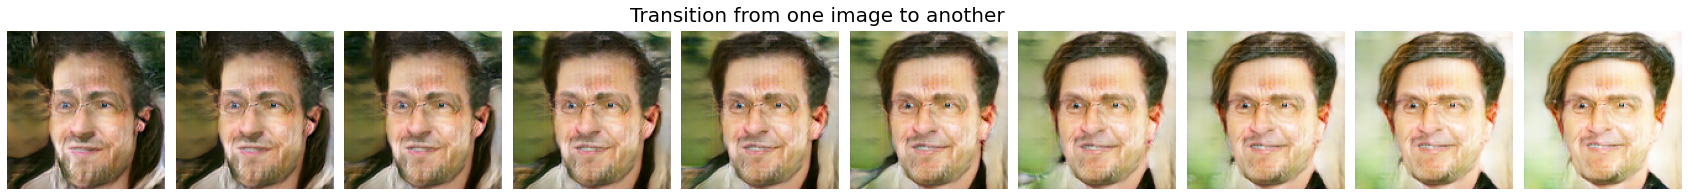

In [21]:
images = interpolation()